# REDPy EQ Family Plot

In [1]:
import redpy.config
import redpy.table
import redpy.plotting
#import numpy as np


In [2]:
from tables import *
import numpy as np
import matplotlib
import datetime
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates
import time
import pandas as pd
import redpy.cluster
import redpy.correlation
from redpy.optics import *
import os
import shutil
import glob
import urllib
from obspy import UTCDateTime
from obspy.geodetics import locations2degrees
from obspy.taup import TauPyModel
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.transforms import offset_copy
from bokeh.plotting import figure, output_file, save, gridplot
from bokeh.models import HoverTool, ColumnDataSource, OpenURL, TapTool, Range1d, Div, Span
from bokeh.models import Arrow, VeeHead, ColorBar, LogColorMapper, LogTicker, LabelSet
from bokeh.models.glyphs import Line, Quad
from bokeh.layouts import column
from bokeh.palettes import inferno, all_palettes
import urllib.request

In [3]:
config = '/Users/jjw2/Development/REDPy_svgfigures/agung_grlB2.cfg'
opt = redpy.config.Options(config)
h5file, rtable, otable, ttable, ctable, jtable, dtable, ftable = redpy.table.openTable(opt)


In [4]:
dt = rtable.cols.startTimeMPL[:]
fi = np.nanmean(rtable.cols.FI[:], axis=1)
longevity = ftable.cols.longevity[:]
famstarts = ftable.cols.startTime[:]
alltrigs = ttable.cols.startTimeMPL[:]
    
# Read in annotation file (if it exists)
if opt.anotfile != '':
    df = pd.read_csv(opt.anotfile)
    
# Create histogram of events/dybin
histT, hT = np.histogram(alltrigs, bins=np.arange(min(alltrigs),
    max(alltrigs+opt.dybin), opt.dybin))
histR, hR = np.histogram(dt, bins=np.arange(min(alltrigs),
    max(alltrigs+opt.dybin), opt.dybin))
        
# Determine padding for hover bars (~1% of window range on each side)
barpad = (max(alltrigs)-min(alltrigs))*0.01
barpadr = opt.recplot*0.01
        
# Create histogram of events/hrbin
histTr, hTr = np.histogram(alltrigs, bins=np.arange(max(alltrigs)-opt.recplot,
    max(alltrigs+opt.hrbin/24), opt.hrbin/24))
histRr, hRr = np.histogram(dt, bins=np.arange(max(alltrigs)-opt.recplot,
    max(alltrigs+opt.hrbin/24), opt.hrbin/24))

## bokeh Families

In [5]:
    # Build hover to show an image of the cluster core
    hover = HoverTool(
        tooltips="""
        <div>
        <div>
            <img src="./clusters/@famnum.png" style="height: 100px; width: 500px;
                vertical-align: middle;" />
            <span style="font-size: 9px; font-family: Helvetica;">Cluster ID: </span>
            <span style="font-size: 12px; font-family: Helvetica;">@famnum</span>
        </div>
        </div>
        """, names=["patch"])
    
    TOOLS = [hover,'pan,box_zoom,reset,save,tap']
    
    # Build hover to show an image of the cluster core
    hoverr = HoverTool(
        tooltips="""
        <div>
        <div>
            <img src="./clusters/@famnum.png" style="height: 100px; width: 500px;
                vertical-align: middle;" />
            <span style="font-size: 9px; font-family: Helvetica;">Cluster ID: </span>
            <span style="font-size: 12px; font-family: Helvetica;">@famnum</span>
        </div>
        </div>
        """, names=["patchr"])
    
    TOOLSrec = [hoverr,'pan,box_zoom,reset,save,tap']
        
    p1 = figure(tools=TOOLS, plot_width=1250, plot_height=500, x_axis_type='datetime',
        title='Occurrence Timeline')
    p1.grid.grid_line_alpha = 0.3
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = 'Cluster by Date ({}+ Members)'.format(opt.minplot)
    
    if opt.anotfile != '':
        for row in df.itertuples():
            spantime = (datetime.datetime.strptime(row[1]
                ,'%Y-%m-%dT%H:%M:%S')-datetime.datetime(1970, 1, 1)).total_seconds()
            p1.add_layout(Span(location=spantime*1000, dimension='height',
                line_color=row[2], line_width=row[3], line_dash=row[4],
                line_alpha=row[5]))


    # Steal YlOrRd (len=256) colormap from matplotlib
    colormap = matplotlib.cm.get_cmap('YlOrRd')
    bokehpalette = [matplotlib.colors.rgb2hex(m) for m in colormap(
        np.arange(colormap.N)[::-1])]
    
    # Build the lists and dictionaries    
    n = 0  
    m = 0
    cloc1 = 335
    cloc2 = 335

    
    for clustNum in range(ftable.attrs.nClust):
        
        members = np.fromstring(ftable[clustNum]['members'], dtype=int, sep=' ')
        
        # Create histogram of events/hour
        hist, h = np.histogram(dt[members], bins=np.arange(min(dt[members]),
            max(dt[members]+1.0/24), 1.0/24))
        d1 = matplotlib.dates.num2date(h[np.where(hist>0)])
        d2 = matplotlib.dates.num2date(h[np.where(hist>0)]+1.0/24)
        histlog = np.log10(hist[hist>0])
        ind = [int(min(255,255*(i/2))) for i in histlog]
        colors = [bokehpalette[i] for i in ind]
                
        if len(dt[members]) >= opt.minplot:
            
            source = ColumnDataSource(dict(x=np.array((matplotlib.dates.num2date(
                min(dt[members])), matplotlib.dates.num2date(max(dt[members])))),
                y=np.array((n, n))))
            p1.add_glyph(source, Line(x="x", y="y", line_color='black'))
            
            source = ColumnDataSource(dict(top=np.ones(len(d1))*(n+0.3),
                bottom=np.ones(len(d1))*(n-0.3), left=np.array(d1), right=np.array(d2),
                color=np.array(colors)))
            p1.add_glyph(source, Quad(left="left", right="right", top="top",
                bottom="bottom", fill_color="color", line_color=None))
            
            p1.add_layout(LabelSet(x=matplotlib.dates.num2date(
                max(h[np.where(hist>0)]+1.0/24)),
                y=n, text=['{}'.format(len(dt[members]))], level='glyph',
                x_offset=5, y_offset=0, render_mode='canvas', text_font_size='9pt',
                text_baseline='middle'))
                 
            # Build source for hover patches
            fnum = clustNum
            if n == 0:
                xs=[[matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad)]]
                ys=[[n-0.5, n+0.5, n+0.5, n-0.5]]
                famnum=[[fnum]]
            else:
                xs.append([matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad)])
                ys.append([n-0.5, n+0.5, n+0.5, n-0.5])
                famnum.append([fnum])
            
            n = n+1
            


In [6]:
from bokeh.io import show
show(p1)

## matplotlib Families

In [13]:
# figure parameters
minplot = 5

# Steal YlOrRd (len=256) colormap from matplotlib
colormap = matplotlib.cm.get_cmap('YlOrRd')
bokehpalette = [matplotlib.colors.rgb2hex(m) for m in colormap(
    np.arange(colormap.N)[::-1])]

n = 0  
m = 0
cloc1 = 335
cloc2 = 335

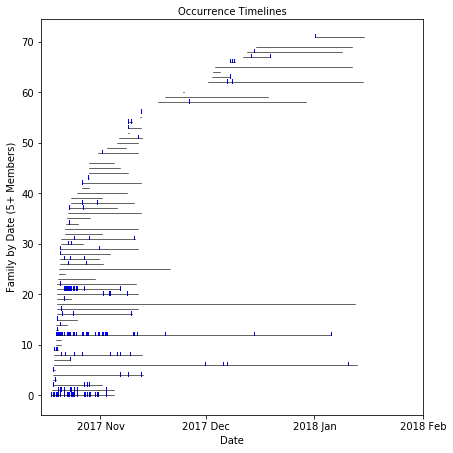

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection, PatchCollection
import numpy as np
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# define figure
fig = plt.figure(figsize=[6.4,6.4], tight_layout=True)
ax = fig.add_subplot(1,1,1)
plt.title('Occurrence Timelines', fontsize=10)
plt.xlabel('Date', fontname='Times', fontsize=10)
plt.ylabel('Family by Date ({}+ Members)'.format(minplot), fontname='Times', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

# populate figure
for clustNum in range(ftable.attrs.nClust):
    
    members = np.fromstring(ftable[clustNum]['members'], dtype=int, sep=' ')
    # print(members)

    # Create histogram of events/hour
    hist, h = np.histogram(dt[members], bins=np.arange(min(dt[members]),
        max(dt[members]+1.0/24), 1.0/24))

    d1 = matplotlib.dates.num2date(h[np.where(hist>0)])
    d2 = matplotlib.dates.num2date(h[np.where(hist>0)]+1.0/24)
    histlog = np.log10(hist[hist>0])
    ind = [int(min(255,255*(i/2))) for i in histlog]
    colors = [bokehpalette[i] for i in ind]
    
    #print(d1)
    #print(d2)
    #print(histlog)
    
    if len(dt[members]) >= minplot:
        
        # add line for family
        x = np.array((matplotlib.dates.num2date(min(dt[members])),
                      matplotlib.dates.num2date(max(dt[members]))))
        y = np.array((n, n))
        ax.plot(x,y, color='black', linewidth=0.6)

        
        # add blocks for family
        rect = []
        for d in d1:
            bottom = n-0.3; left = matplotlib.dates.date2num(d)
            rect.append(Rectangle((left,bottom), 1.0/24, 0.9))
        pc = PatchCollection(rect, facecolor='blue', alpha=1,
                         edgecolor=None)
        ax.add_collection(pc)
        
        # add labels
        label_x = matplotlib.dates.num2date(max(h[np.where(hist>0)]+1.0/24))
        label_y = n
        
        #p1.add_layout(LabelSet(x=matplotlib.dates.num2date(
        #    max(h[np.where(hist>0)]+1.0/24)),
        #    y=n, text=['{}'.format(len(dt[members]))], level='glyph',
        #    x_offset=5, y_offset=0, render_mode='canvas', text_font_size='9pt',
        #    text_baseline='middle'))
        
        
        n +=1 # increment plot axis number
        
        
# define xdatetime axis
import pandas as pd
import datetime
drng = pd.date_range(start='2017/11/1', end='2018/2/1', freq='MS')
xticks = drng.to_pydatetime()
xtick_labels = list(drng.strftime('%Y %b'))
plt.xticks(xticks, xtick_labels)
ax.set_xlim([datetime.datetime(2017,10,15), xticks[-1]])

# show and save
fig.show()
fig.savefig('/Users/jjw2/Desktop/REDPy_test_Families.png', dpi=450, facecolor=None, edgecolor=None,
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0,
        frameon=None, metadata=None)

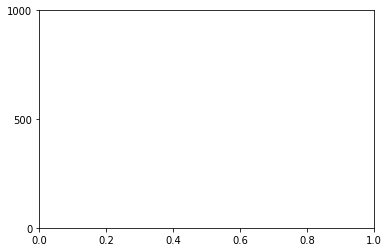

In [9]:
ax.plot(matplotlib.dates.num2date(hT[0:-1]+opt.dybin/2), histT, color='black', label='All EQs')
#ax.plot(matplotlib.dates.num2date(hT[0:-1]+opt.dybin/2), histT-histR, color='black', label='Orphans')
ax.plot(matplotlib.dates.num2date(hR[0:-1]+opt.dybin/2), histR, color='red', linewidth=2, label='Repeaters')

plt.yticks([0,500,1000])
ax.set_ylim([0,1000])
ax.legend()





In [10]:

    p1.grid.grid_line_alpha = 0.3
    
    if opt.anotfile != '':
        for row in df.itertuples():
            spantime = (datetime.datetime.strptime(row[1]
                ,'%Y-%m-%dT%H:%M:%S')-datetime.datetime(1970, 1, 1)).total_seconds()
            p1.add_layout(Span(location=spantime*1000, dimension='height',
                line_color=row[2], line_width=row[3], line_dash=row[4],
                line_alpha=row[5]))


    # Steal YlOrRd (len=256) colormap from matplotlib
    colormap = matplotlib.cm.get_cmap('YlOrRd')
    bokehpalette = [matplotlib.colors.rgb2hex(m) for m in colormap(
        np.arange(colormap.N)[::-1])]
    
    # Build the lists and dictionaries    
    n = 0  
    m = 0
    cloc1 = 335
    cloc2 = 335

    
    for clustNum in range(ftable.attrs.nClust):
        
        members = np.fromstring(ftable[clustNum]['members'], dtype=int, sep=' ')
        
        # Create histogram of events/hour
        hist, h = np.histogram(dt[members], bins=np.arange(min(dt[members]),
            max(dt[members]+1.0/24), 1.0/24))
        d1 = matplotlib.dates.num2date(h[np.where(hist>0)])
        d2 = matplotlib.dates.num2date(h[np.where(hist>0)]+1.0/24)
        histlog = np.log10(hist[hist>0])
        ind = [int(min(255,255*(i/2))) for i in histlog]
        colors = [bokehpalette[i] for i in ind]
                
        if len(dt[members]) >= opt.minplot:
            
            source = ColumnDataSource(dict(x=np.array((matplotlib.dates.num2date(
                min(dt[members])), matplotlib.dates.num2date(max(dt[members])))),
                y=np.array((n, n))))
            p1.add_glyph(source, Line(x="x", y="y", line_color='black'))
            
            source = ColumnDataSource(dict(top=np.ones(len(d1))*(n+0.3),
                bottom=np.ones(len(d1))*(n-0.3), left=np.array(d1), right=np.array(d2),
                color=np.array(colors)))
            p1.add_glyph(source, Quad(left="left", right="right", top="top",
                bottom="bottom", fill_color="color", line_color=None))
            
            p1.add_layout(LabelSet(x=matplotlib.dates.num2date(
                max(h[np.where(hist>0)]+1.0/24)),
                y=n, text=['{}'.format(len(dt[members]))], level='glyph',
                x_offset=5, y_offset=0, render_mode='canvas', text_font_size='9pt',
                text_baseline='middle'))
                 
            # Build source for hover patches
            fnum = clustNum
            if n == 0:
                xs=[[matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad)]]
                ys=[[n-0.5, n+0.5, n+0.5, n-0.5]]
                famnum=[[fnum]]
            else:
                xs.append([matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(min(dt[members])-barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad),
                    matplotlib.dates.num2date(max(dt[members])+barpad)])
                ys.append([n-0.5, n+0.5, n+0.5, n-0.5])
                famnum.append([fnum])
            
            n = n+1
            


In [11]:
fig.savefig('/Users/jjw2/Desktop/TestFigure.png', dpi=450, facecolor=None, edgecolor=None,
        orientation='portrait', papertype=None,
        transparent=True, bbox_inches=None, pad_inches=0,
        frameon=None, metadata=None)